In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm

c:\Users\victo\anaconda3\envs\montecarlo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def operator(K, s, r, m, l):
    i_arr = np.linspace(1, l, l)
    sub_diag = (-r*i_arr[1:] + s**2 * (i_arr[1:])**2)/2
    diag_arr = -s**2 * (i_arr**2) - r
    sup_diag = (r*i_arr[:-1] + s**2 * (i_arr[:-1])**2)/2

    return np.diag(sub_diag, -1) + np.diag(diag_arr) + np.diag(sup_diag, 1)

def add_bc(t, K, T, r, l):
    return np.concatenate([np.array([(s**2 - r)/2 * K*np.exp(-r*(T-t))]),np.zeros(l-1)])

def payoff(x, K, put_or_call='call'):
    if put_or_call == 'call':
        return np.maximum(x - K, 0)
    elif put_or_call == 'put':
        return np.maximum(K - x, 0)

In [28]:
def finite_differences(K, s, r, T, m, l, alpha, beta, theta):
    delta = (beta - alpha)/(l+1)
    h = T/m

    print(f'delta: {delta}, h: {h}')
    
    x_grid = np.array([alpha + delta*i for i in range(1, l+1)])
    u  = [0]*(m+1)
    u[-1] = payoff(x_grid, K, 'put')   # terminal condition
    A = operator(K, s, r, m, l)

    for i in tqdm(range(m - 1, -1, -1)):
        u[i] = np.dot(np.linalg.inv(np.eye(l) - theta*h*A),(np.dot(np.eye(l) + (1-theta)*h*A, u[i+1]) + h*add_bc(i*h, K, T, r, l)))

    return x_grid, u[0]

Computation of the price

In [29]:
K = 100
s = 0.2
r = 0.05
T = 1
m = 1000
l = 500
alpha = 0
beta = 200

grid, sol = finite_differences(K, s, r, T, m, l, alpha, beta, 1)

wanted_x = 100
index = np.where(grid >= wanted_x)[0][0]
print(f'Interpolate between {grid[index-1]} and {grid[index]}')

price = sol[index-1] + (sol[index] - sol[index-1]) * (wanted_x - grid[index-1]) / (grid[index] - grid[index-1])

print(f'Price at x={wanted_x}: {price}')

delta: 0.3992015968063872, h: 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|▉         | 98/1000 [00:24<03:45,  4.00it/s]


KeyboardInterrupt: 

**Using exact formula**

In [26]:
def analytical(K, s, r, T, wanted_x):
    d1 = (np.log(wanted_x/K) + (r + s**2/2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)

    P = np.exp(-r*T)*K*norm.cdf(-d2) - wanted_x*norm.cdf(-d1)
    return P

P = analytical(K, s, r, T, wanted_x)
print(f'Price at x={wanted_x} (analytical): {P}')

Price at x=100 (analytical): 5.573526022256971


**Determination of the convergence order in time**

delta: 0.49916805324459235, h: 0.1


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 12.37it/s]


delta: 0.49916805324459235, h: 0.01


100%|██████████| 100/100 [00:03<00:00, 26.44it/s]


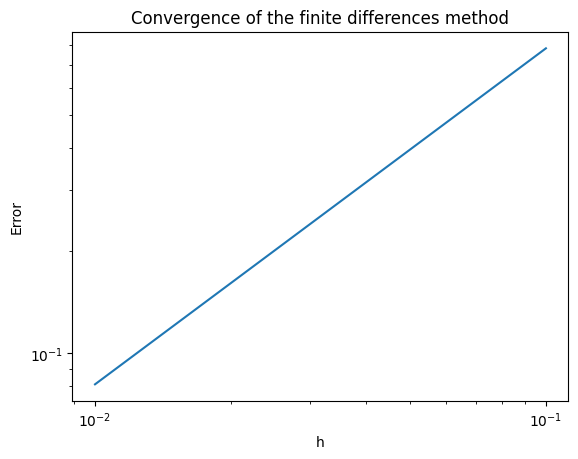

Errors: [0.7823942145828581, 0.08116071525063479]
Order of convergence: 0.9840797646840216


In [174]:
K = 100
s = 0.2
r = 0.05
T = 1
l = 600
alpha = 0
beta = 300

delta = (beta - alpha)/(l+1)
wanted_x = 100

h_values = [0.1, 0.01]

grid = np.array([alpha + delta*i for i in range(1, l+1)])
analytical_sol = analytical(K, s, r, T, grid)

solutions = []
errors = []

for h in h_values:
    m = int(T/h)
    grid, sol = finite_differences(K, s, r, T, m, l, alpha, beta, 1)
    solutions.append(sol)
    errors.append(np.sqrt(np.sum((sol - analytical_sol)**2)))

plt.plot([h for h in h_values], errors)
plt.title('Convergence of the finite differences method')
plt.xlabel('h')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.show()
print('Errors:', errors)
print('Order of convergence:', np.log(errors[-1]/errors[-2])/np.log(h_values[-1]/h_values[-2]))

**Order of convergence in space**

delta: 16.666666666666668, h: 0.01


100%|██████████| 100/100 [00:00<00:00, 10727.94it/s]


delta: 8.0, h: 0.01


100%|██████████| 100/100 [00:00<00:00, 2026.95it/s]


delta: 4.0, h: 0.01


100%|██████████| 100/100 [00:00<00:00, 1026.48it/s]


delta: 2.0, h: 0.01


100%|██████████| 100/100 [00:00<00:00, 465.60it/s]


delta: 1.0, h: 0.01


100%|██████████| 100/100 [00:00<00:00, 239.34it/s]


delta: 0.5, h: 0.01


100%|██████████| 100/100 [00:01<00:00, 52.35it/s]


delta: 16.666666666666668, h: 0.005


100%|██████████| 200/200 [00:00<00:00, 4543.94it/s]


delta: 8.0, h: 0.005


100%|██████████| 200/200 [00:00<00:00, 3303.36it/s]


delta: 4.0, h: 0.005


100%|██████████| 200/200 [00:00<00:00, 1438.99it/s]


delta: 2.0, h: 0.005


100%|██████████| 200/200 [00:00<00:00, 621.59it/s]


delta: 1.0, h: 0.005


100%|██████████| 200/200 [00:00<00:00, 248.79it/s]


delta: 0.5, h: 0.005


100%|██████████| 200/200 [00:03<00:00, 52.19it/s]


delta: 16.666666666666668, h: 0.0025


100%|██████████| 400/400 [00:00<00:00, 5668.97it/s]


delta: 8.0, h: 0.0025


100%|██████████| 400/400 [00:00<00:00, 2031.99it/s]


delta: 4.0, h: 0.0025


100%|██████████| 400/400 [00:00<00:00, 1474.44it/s]


delta: 2.0, h: 0.0025


100%|██████████| 400/400 [00:00<00:00, 608.33it/s]


delta: 1.0, h: 0.0025


100%|██████████| 400/400 [00:02<00:00, 183.98it/s]


delta: 0.5, h: 0.0025


100%|██████████| 400/400 [00:08<00:00, 48.32it/s]


delta: 16.666666666666668, h: 0.00125


100%|██████████| 800/800 [00:00<00:00, 5363.05it/s]


delta: 8.0, h: 0.00125


100%|██████████| 800/800 [00:00<00:00, 3451.73it/s]


delta: 4.0, h: 0.00125


100%|██████████| 800/800 [00:00<00:00, 1439.56it/s]


delta: 2.0, h: 0.00125


100%|██████████| 800/800 [00:01<00:00, 590.15it/s]


delta: 1.0, h: 0.00125


100%|██████████| 800/800 [00:03<00:00, 223.09it/s]


delta: 0.5, h: 0.00125


100%|██████████| 800/800 [00:22<00:00, 35.67it/s]


delta: 16.666666666666668, h: 0.000625


100%|██████████| 1600/1600 [00:00<00:00, 7112.69it/s]


delta: 8.0, h: 0.000625


100%|██████████| 1600/1600 [00:00<00:00, 3052.69it/s]


delta: 4.0, h: 0.000625


100%|██████████| 1600/1600 [00:00<00:00, 1622.41it/s]


delta: 2.0, h: 0.000625


100%|██████████| 1600/1600 [00:02<00:00, 569.81it/s]


delta: 1.0, h: 0.000625


100%|██████████| 1600/1600 [00:07<00:00, 218.33it/s]


delta: 0.5, h: 0.000625


100%|██████████| 1600/1600 [00:29<00:00, 53.35it/s]


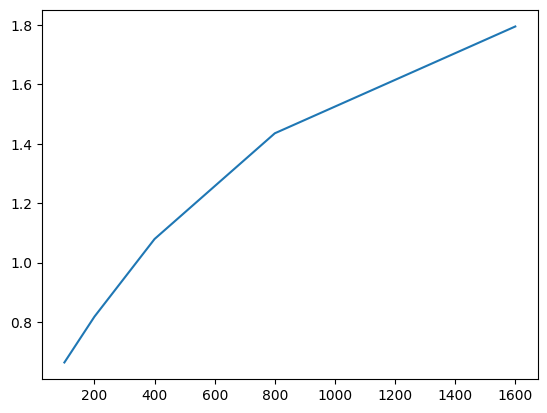

In [182]:
def cv(m):
    K = 100
    s = 0.2
    r = 0.05
    T = 1
    # m = 100
    alpha = 0
    beta = 200

    wanted_x = 100

    delta_values = [16, 8, 4, 2, 1, 0.5]

    solutions = []
    errors = []

    for delta in delta_values:
        l = int((beta - alpha)/delta) - 1
        grid, sol = finite_differences(K, s, r, T, m, l, alpha, beta, 1)
        analytical_sol = analytical(K, s, r, T, grid)
        solutions.append(sol)
        errors.append(np.sqrt(np.sum((sol - analytical_sol)**2))*delta)

    cv_order = np.log(errors[-1]/errors[-2])/np.log(delta_values[-1]/delta_values[-2])

    # plt.plot([delta for delta in delta_values], errors)
    # plt.title('Convergence of the finite differences method')
    # plt.xlabel('h')
    # plt.ylabel('Error')
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.show()
    # print('Errors:', errors)
    # print('Order of convergence:', cv_order)
    return cv_order

m_values = [100, 200, 400, 800, 1600]
cv_orders = [cv(m) for m in m_values]
plt.plot(m_values, cv_orders)